In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np
import sys

from matplotlib.gridspec import GridSpec

from numpy.polynomial.legendre import legval,legfit
import matplotlib as mpl
mpl.rcParams['font.size']=18
mpl.rcParams['font.serif'] = "Bitstream Vera Serif"
mpl.rcParams['font.family'] = "serif"



In [3]:
def filter_with_legPoly(cpsi,cor,max_deg):
    deg = range(0,max_deg,2)
    cor_legfit = np.zeros_like(cor)
    for ii in range(cor.shape[0]):
        x=cpsi[ii]
        cc=legfit(x,cor[ii],deg)
        cor_legfit[ii] = legval(x,cc)
    return cor_legfit

def leg_coefs(cpsi,cor,max_deg):
    deg = range(0,max_deg,2)
    coefs=[]
    for ii in range(cor.shape[0]):
        x=cpsi[ii]
        cc=legfit(x,cor[ii],deg)
        coefs.append(cc)
    return np.array(coefs)



def legfit_residual(cpsi,cor,max_deg):
    res=[]
    for mm in range(2,max_deg,2):
        fit = filter_with_legPoly(cpsi,cor,mm)
        res.append(np.abs(fit-cor))
    return np.array(res)

def filter_with_legPoly2(cpsi,cor,max_deg):
    
    cor_legfit = np.zeros_like(cor)
    for ii in range(cor.shape[0]):
        deg = range(0,max_deg[ii],2)
        x=cpsi[ii]
        cc=legfit(x,cor[ii],deg)
        cor_legfit[ii] = legval(x,cc)
    return cor_legfit

def normalize_cor(cor):
    x=cor-cor.min(-1)[:,None]
#     return x/x.max(-1)[:,None]
    return x/x.mean(-1)[:,None]
#
def symmetrize(diff):
    num_phi = diff.shape[-1]
    return 0.5*(diff[:,:num_phi/2]+diff[:,num_phi/2:])

In [104]:
f=h5py.File('/reg/d/psdm/cxi/cxilr6716/scratch/cali_gai_cor_results/pca_remove_result.h5','r')
f0=h5py.File('/reg/d/psdm/cxi/cxilr6716/scratch/cali_gai_cor_results/pca0_result.h5','r')

GDP_lmax = np.load('GDP_legfit_lmax.npy')
ALF_lmax = np.load('ALF_legfit_lmax.npy')

qvalues=np.load('/reg/neh/home/qiaoshen/run16_notebooks/encodeZ400_qvalue.npy')[:36]

num_phi = 326
phi_offset=15
exp_cpsi=np.load('/reg/neh/home/qiaoshen/run16_notebooks/encodeZ400_cpsi.npy')[:36,phi_offset:num_phi/2-phi_offset]

ALFdiff = symmetrize(f['ALF_diff'].value)[:,phi_offset:num_phi/2-phi_offset]
ALFerr = symmetrize(f['ALFdiff_err'].value)[:,phi_offset:num_phi/2-phi_offset]

GDPdiff = symmetrize(f['GDP_diff'].value)[:,phi_offset:num_phi/2-phi_offset]
GDPerr = symmetrize(f['GDPdiff_err'].value)[:,phi_offset:num_phi/2-phi_offset]

ALFdiff0 = symmetrize(f0['ALF_diff'].value)[:,phi_offset:num_phi/2-phi_offset]
ALFerr0 = symmetrize(f0['ALFdiff_err'].value)[:,phi_offset:num_phi/2-phi_offset]

GDPdiff0 = symmetrize(f0['GDP_diff'].value)[:,phi_offset:num_phi/2-phi_offset]
GDPerr0 = symmetrize(f0['GDPdiff_err'].value)[:,phi_offset:num_phi/2-phi_offset]

In [105]:
ALFdiff_legfit = filter_with_legPoly2(exp_cpsi,ALFdiff,ALF_lmax)

ALFdiff0_legfit = filter_with_legPoly2(exp_cpsi,ALFdiff0,ALF_lmax)
GDPdiff_legfit = filter_with_legPoly2(exp_cpsi,GDPdiff,GDP_lmax)
GDPdiff0_legfit = filter_with_legPoly2(exp_cpsi,GDPdiff0,GDP_lmax)

ALFsnr = (ALFdiff_legfit-ALFdiff_legfit.min(-1)[:,None])/ALFerr
ALFsnr0 = (ALFdiff0_legfit-ALFdiff0_legfit.min(-1)[:,None])/ALFerr0

GDPsnr = (GDPdiff_legfit-GDPdiff_legfit.min(-1)[:,None])/GDPerr
GDPsnr0 = (GDPdiff0_legfit-GDPdiff0_legfit.min(-1)[:,None])/GDPerr0

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 18, 19, 20,
        25, 26, 27, 28, 31, 34]),)

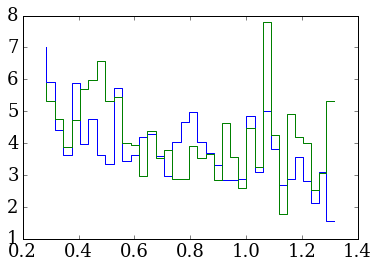

In [117]:
plt.step(qvalues, GDPsnr.mean(-1))
plt.step(qvalues, ALFsnr.mean(-1))
snr_cutoff=3
np.where((GDPsnr.mean(-1)>snr_cutoff)*(ALFsnr.mean(-1)>snr_cutoff))

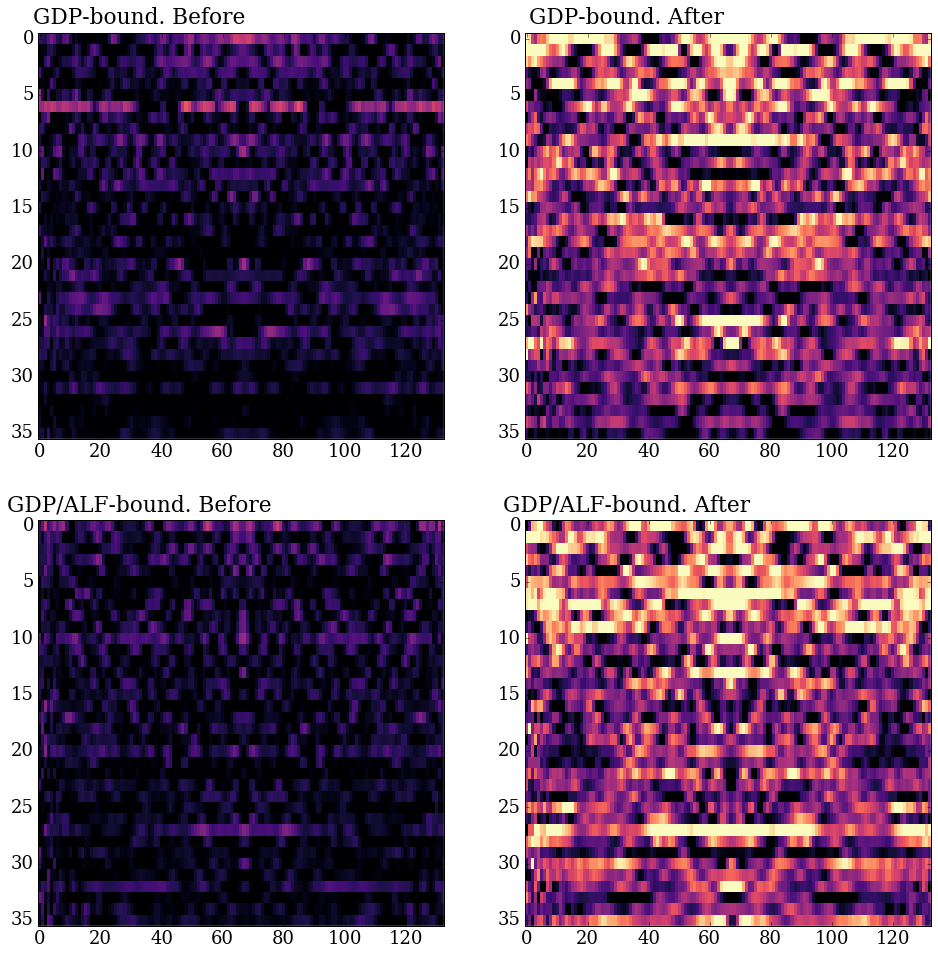

In [129]:
#### compare SNR before and after

x =1
y = 8
gs = GridSpec(2,2)
plt.figure(figsize=[16,16])
ax=plt.subplot(gs[0,0])
ax.set_title('GDP-bound. Before', x = 0.25, y = 1.01)
plt.imshow(GDPsnr0, aspect='auto', cmap='magma',
          vmin = x, vmax = y, interpolation='none')
ax=plt.subplot(gs[0,1])
ax.set_title('GDP-bound. After', x = 0.25, y = 1.01)
plt.imshow(GDPsnr, aspect='auto', cmap='magma',
          vmin = x, vmax = y, interpolation='none')
# plt.colorbar()

#####ALF

ax=plt.subplot(gs[1,0])
ax.set_title('GDP/ALF-bound. Before', x = 0.25, y = 1.01)
plt.imshow(ALFsnr0, aspect='auto', cmap='magma',
          vmin = x, vmax = y, interpolation='none')
ax=plt.subplot(gs[1,1])
ax.set_title('GDP/ALF-bound. After', x = 0.25, y = 1.01)

plt.imshow(ALFsnr, aspect='auto', cmap='magma',
          vmin = x, vmax = y, interpolation='none')

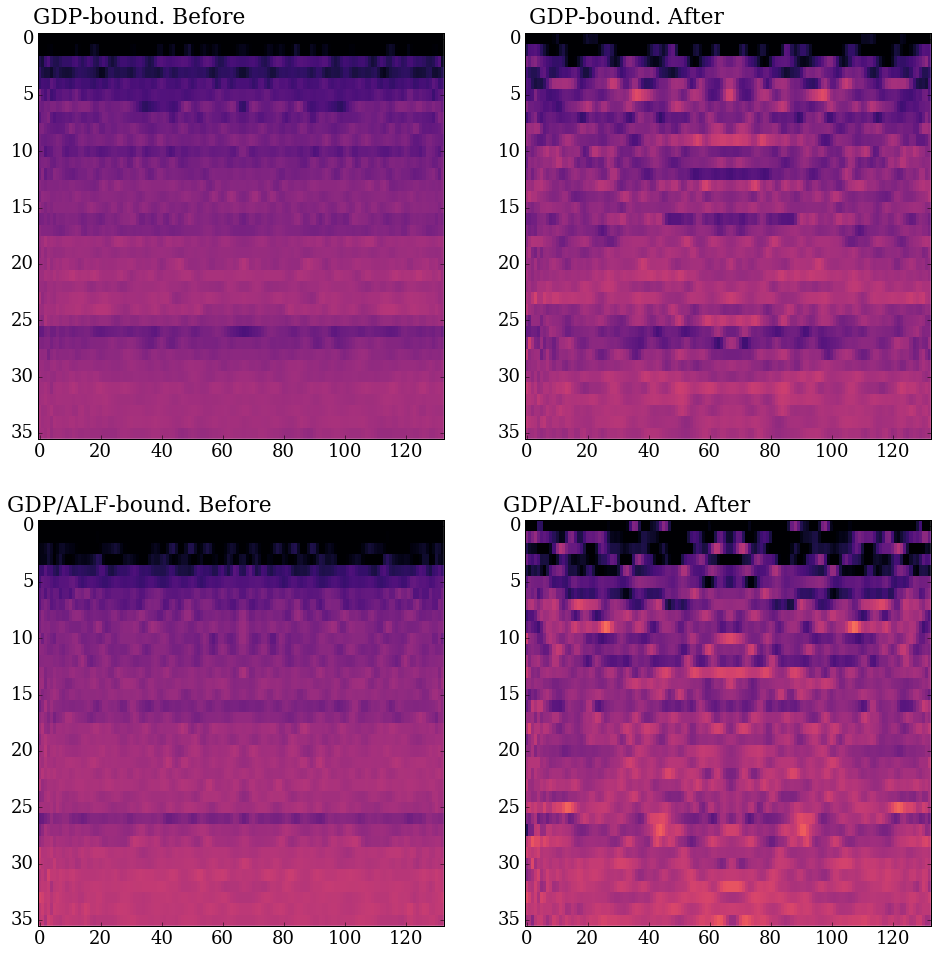

In [143]:
#### compare correlations before and after

x =-5e5
y = 3e5
gs = GridSpec(2,2)
plt.figure(figsize=[16,16])
ax=plt.subplot(gs[0,0])
ax.set_title('GDP-bound. Before', x = 0.25, y = 1.01)
plt.imshow(GDPdiff0_legfit, aspect='auto', cmap='magma',
          vmin = x, vmax = y, interpolation='none')
ax=plt.subplot(gs[0,1])
ax.set_title('GDP-bound. After', x = 0.25, y = 1.01)
plt.imshow(GDPdiff_legfit, aspect='auto', cmap='magma',
          vmin = x, vmax = y, interpolation='none')
# plt.colorbar()

#####ALF

ax=plt.subplot(gs[1,0])
ax.set_title('GDP/ALF-bound. Before', x = 0.25, y = 1.01)
plt.imshow(ALFdiff0_legfit, aspect='auto', cmap='magma',
          vmin = x, vmax = y, interpolation='none')
ax=plt.subplot(gs[1,1])
ax.set_title('GDP/ALF-bound. After', x = 0.25, y = 1.01)

plt.imshow(ALFdiff_legfit, aspect='auto', cmap='magma',
          vmin = x, vmax = y, interpolation='none')

[78, 78, 68, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78]


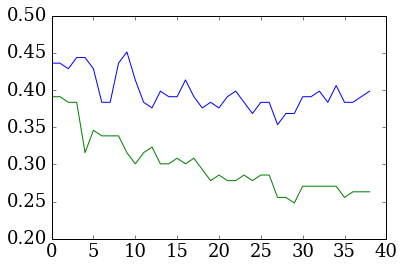

In [103]:

# plt.ylim(0.1,5)
fit_quality = np.array([(GDPres[:,ii,:]>1).sum(-1)/float(GDPres.shape[-1]) for ii in range(36)])
fit_quality0 = np.array([(GDPres0[:,ii,:]>1).sum(-1)/float(GDPres.shape[-1]) for ii in range(36)])
qidx =35
plt.plot(fit_quality[qidx,:])
plt.plot(fit_quality0[qidx,:])
threshold=0.05
inds = []
for ii in range(0,36):
    x=np.where(fit_quality[ii]>threshold)[0]
    if len(x)>0:
        inds.append(range(2,max_degree,2)[x[-1]])
    else:
        inds.append(range(2,max_degree,2)[0])
print inds
# np.save('GDP_legfit_lmax.npy',np.array(inds))
# [np.where(fit_quality[ii]>threshold)[0] for ii in range(35)]

In [41]:
d=80
ALFdiff_legfit = filter_with_legPoly(exp_cpsi,ALFdiff,max_deg=d)

ALFdiff0_legfit = filter_with_legPoly(exp_cpsi,ALFdiff0,max_deg=d)
GDPdiff_legfit = filter_with_legPoly(exp_cpsi,GDPdiff,max_deg=d)
GDPdiff0_legfit = filter_with_legPoly(exp_cpsi,GDPdiff0,max_deg=d)


<Container object of 3 artists>

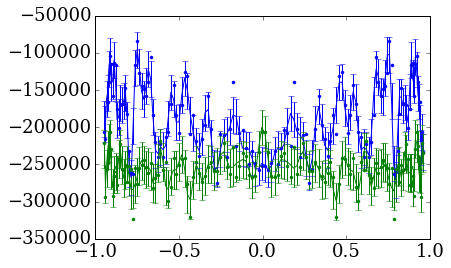

In [140]:
qidx =10
plt.plot(exp_cpsi[qidx],GDPdiff[qidx],'b.')
plt.errorbar(exp_cpsi[qidx],GDPdiff_legfit[qidx], yerr=GDPerr[qidx])
plt.plot(exp_cpsi[qidx],GDPdiff0[qidx],'g.')
plt.errorbar(exp_cpsi[qidx],GDPdiff0_legfit[qidx], yerr=GDPerr0[qidx])

# plt.plot(exp_cpsi[qidx],ALFdiff[qidx],'b.')
# plt.errorbar(exp_cpsi[qidx],ALFdiff_legfit[qidx], yerr=ALFerr[qidx])
# plt.plot(exp_cpsi[qidx],ALFdiff0[qidx],'g.')
# plt.errorbar(exp_cpsi[qidx],ALFdiff0_legfit[qidx], yerr=ALFerr0[qidx])

<Container object of 3 artists>

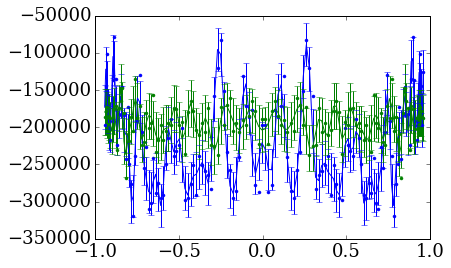

In [115]:
qidx =12
plt.plot(exp_cpsi[qidx],ALFdiff[qidx],'b.')
plt.errorbar(exp_cpsi[qidx],ALFdiff_legfit[qidx], yerr=ALFerr[qidx])
plt.plot(exp_cpsi[qidx],ALFdiff0[qidx],'g.')
plt.errorbar(exp_cpsi[qidx],ALFdiff0_legfit[qidx], yerr=ALFerr0[qidx])

In [30]:
ALFres.shape

(39, 36, 133)

In [29]:
fit_quality.shape

(35, 39)

In [70]:
np.where(fit_quality[ii]>threshold)[-1]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43])

In [74]:
np.where(fit_quality[0]>0.5)[0][-1]

9

In [91]:
GDP_lmax.shape

(35,)

In [102]:
len(inds)

36

In [101]:
GDP_lmax.shape

(35,)